## Кейс №2 - Приложение доставки

In [122]:
from scipy.stats import bootstrap

import pandas as pd
import numpy as np
import seaborn as sns

import plotly.express as px
import pingouin as pg

import scipy.stats as stats
from scipy.stats import chi2_contingency

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

- **ab_users_data** – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
- **ab_orders** – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
- **ab_products** – подробная информация о продуктах, их название и стоимость

Загружаем данные:

In [2]:
users_data  = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-soloveva/Статистика/ab_users_data.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-soloveva/Статистика/ab_orders.csv')
products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-soloveva/Статистика/ab_products.csv')

Подготовим данные

In [3]:
users_data

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


In [4]:
users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [5]:
users_data[users_data.action == 'cancel_order']

,user_id,order_id,action,time,date,group
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0
47,995,1298,cancel_order,2022-08-26 00:49:51.514240,2022-08-26,0
54,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,1
60,1008,1315,cancel_order,2022-08-26 01:06:11.292953,2022-08-26,0
...,...,...,...,...,...,...
4221,1498,54938,cancel_order,2022-09-08 06:46:29.885081,2022-09-08,0
4255,1658,56612,cancel_order,2022-09-08 13:31:37.085777,2022-09-08,0
4259,1314,56772,cancel_order,2022-09-08 14:09:53.652063,2022-09-08,1
4307,988,58492,cancel_order,2022-09-08 20:07:22.918779,2022-09-08,1


In [9]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   4337 non-null   int64         
 1   order_id  4337 non-null   int64         
 2   action    4337 non-null   object        
 3   time      4337 non-null   datetime64[ns]
 4   date      4337 non-null   datetime64[ns]
 5   group     4337 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 203.4+ KB


Изменяем тип для дат:

In [7]:
users_data.time = pd.to_datetime(users_data.time)
users_data.date = pd.to_datetime(users_data.date)

In [8]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   4337 non-null   int64         
 1   order_id  4337 non-null   int64         
 2   action    4337 non-null   object        
 3   time      4337 non-null   datetime64[ns]
 4   date      4337 non-null   datetime64[ns]
 5   group     4337 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 203.4+ KB


In [10]:
users_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [11]:
orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


Изменяем тип для дат:

In [13]:
orders.creation_time = pd.to_datetime(orders.creation_time)

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       4123 non-null   int64         
 1   creation_time  4123 non-null   datetime64[ns]
 2   product_ids    4123 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 96.8+ KB


In [15]:
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [16]:
products

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
...,...,...,...
82,83,вафли,55.0
83,84,мандарины,90.4
84,85,варенье,200.3
85,86,кофе холодный,70.3


In [17]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [18]:
products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

Пропусков в данных нет, столбцы с данными о дате преобразовали в формат `datetime64`. 

Объединим датафреймы с данными для последующего анализа.

In [19]:
orders_customers = pd.merge(users_data, orders, how='inner', on = 'order_id')
orders_customers

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}"
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03,"{84, 8, 24}"
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}"
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27,"{60, 41, 46}"
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06,"{9, 62, 77}"


In [20]:
orders_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4337 entries, 0 to 4336
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        4337 non-null   int64         
 1   order_id       4337 non-null   int64         
 2   action         4337 non-null   object        
 3   time           4337 non-null   datetime64[ns]
 4   date           4337 non-null   datetime64[ns]
 5   group          4337 non-null   int64         
 6   creation_time  4337 non-null   datetime64[ns]
 7   product_ids    4337 non-null   object        
dtypes: datetime64[ns](3), int64(3), object(2)
memory usage: 304.9+ KB


In [21]:
orders_customers['product_id'] = orders_customers.product_ids.apply(lambda x : x.strip('{}').split(', '))
orders_customers

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_id
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}","[75, 22, 53, 84]"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21,"{56, 76, 39}","[56, 76, 39]"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27,"{76, 34, 41, 38}","[76, 34, 41, 38]"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}","[74, 6]"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}","[74, 6]"
...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03,"{84, 8, 24}","[84, 8, 24]"
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}","[9, 25, 75, 30, 6]"
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27,"{60, 41, 46}","[60, 41, 46]"
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06,"{9, 62, 77}","[9, 62, 77]"


In [22]:
orders_customers = orders_customers.explode('product_id')
orders_customers

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_id
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}",75
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}",22
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}",53
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}",84
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"{56, 76, 39}",56
...,...,...,...,...,...,...,...,...,...
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,"{9, 62, 77}",9
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,"{9, 62, 77}",62
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,"{9, 62, 77}",77
4336,1376,59533,create_order,2022-09-08 23:41:24,2022-09-08,0,2022-09-08 23:41:24,"{17, 85}",17


In [23]:
orders_customers.product_id = orders_customers.product_id.astype(int)
orders_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14569 entries, 0 to 4336
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        14569 non-null  int64         
 1   order_id       14569 non-null  int64         
 2   action         14569 non-null  object        
 3   time           14569 non-null  datetime64[ns]
 4   date           14569 non-null  datetime64[ns]
 5   group          14569 non-null  int64         
 6   creation_time  14569 non-null  datetime64[ns]
 7   product_ids    14569 non-null  object        
 8   product_id     14569 non-null  int64         
dtypes: datetime64[ns](3), int64(4), object(2)
memory usage: 1.1+ MB


In [41]:
#Объединим все датафреймы и оставим только те столбцы, которые нам необходимы для последующей обработки данных.
full_data = pd.merge(orders_customers, products, how='left', on='product_id')
full_data_df = full_data[['group','user_id','order_id','action','date','product_id','name','price']]
full_data_df

,group,user_id,order_id,action,date,product_id,name,price
0,0,964,1255,create_order,2022-08-26,75,сок ананасовый,120.0
1,0,964,1255,create_order,2022-08-26,22,сок мультифрукт,120.0
2,0,964,1255,create_order,2022-08-26,53,мука,78.3
3,0,964,1255,create_order,2022-08-26,84,мандарины,90.4
4,1,965,1256,create_order,2022-08-26,56,сосиски,150.0
...,...,...,...,...,...,...,...,...
14564,0,1461,59487,create_order,2022-09-08,9,чай черный листовой,83.5
14565,0,1461,59487,create_order,2022-09-08,62,сок яблочный,120.0
14566,0,1461,59487,create_order,2022-09-08,77,курица,298.4
14567,0,1376,59533,create_order,2022-09-08,17,морс брусничный,190.0


In [36]:
#Поделим наши данные на контрольную и тестовую группы

In [37]:
test = full_data_df[full_data_df.group == 1]
test

,group,user_id,order_id,action,date,product_id,name,price
4,1,965,1256,create_order,2022-08-26,56,сосиски,150.0
5,1,965,1256,create_order,2022-08-26,76,чай черный в пакетиках,55.5
6,1,965,1256,create_order,2022-08-26,39,бублики,45.0
15,1,967,1259,create_order,2022-08-26,20,батон,50.0
16,1,967,1259,create_order,2022-08-26,45,чай зеленый листовой,78.0
...,...,...,...,...,...,...,...,...
14556,1,1418,59439,create_order,2022-09-08,9,чай черный листовой,83.5
14557,1,1418,59439,create_order,2022-09-08,25,кофе растворимый,150.0
14558,1,1418,59439,create_order,2022-09-08,75,сок ананасовый,120.0
14559,1,1418,59439,create_order,2022-09-08,30,энергетический напиток,140.0


In [155]:
control = full_data_df[full_data_df.group == 0]
control

,group,user_id,order_id,action,date,product_id,name,price
0,0,964,1255,create_order,2022-08-26,75,сок ананасовый,120.0
1,0,964,1255,create_order,2022-08-26,22,сок мультифрукт,120.0
2,0,964,1255,create_order,2022-08-26,53,мука,78.3
3,0,964,1255,create_order,2022-08-26,84,мандарины,90.4
7,0,964,1257,create_order,2022-08-26,76,чай черный в пакетиках,55.5
...,...,...,...,...,...,...,...,...
14564,0,1461,59487,create_order,2022-09-08,9,чай черный листовой,83.5
14565,0,1461,59487,create_order,2022-09-08,62,сок яблочный,120.0
14566,0,1461,59487,create_order,2022-09-08,77,курица,298.4
14567,0,1376,59533,create_order,2022-09-08,17,морс брусничный,190.0


In [156]:
control_df = control.groupby(['user_id']).agg({'order_id':'count'})
control_df

,order_id
user_id,
964,8
966,4
968,11
969,8
972,5
...,...
1971,11
1972,11
1973,10


In [64]:
control_df.order_id.sum()

5677

In [61]:
test_df = test.groupby(['user_id']).agg({'order_id':'count'})
test_df

,order_id
user_id,
965,33
967,18
970,7
971,19
973,14
...,...
1976,16
1977,9
1978,23


Исходя из размерности наших групп, мы можем заметить, что после группировки на пользователей в каждой группе и количеству заказов к конкретному пользователю, размерности стали приблизительно равны, то есть можем работать с подготовленными данными.

## Выбор первой метрики
Поскольку нам необходимо оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Будем использовать метрику **процент отмен**, то есть  отношение количества отменённых заказов к общему числу отправлений в обеих группах.

In [71]:
canceled_orders = users_data.groupby(['group','action']).agg({'date':'count'}).pivot_table(index='group',columns='action',values='date')

In [72]:
canceled_orders

action,cancel_order,create_order
group,,
0,82,1609
1,132,2514


In [94]:
pd.crosstab(users_data.group, users_data.action)

action,cancel_order,create_order
group,,
0,82,1609
1,132,2514


In [81]:
control_canceled = ((canceled_orders.loc[0, "cancel_order"]/ control_df.order_id.sum())*100).round(3)
control_canceled

1.444

In [82]:
test_canceled = ((canceled_orders.loc[1, "cancel_order"]/ test_df.order_id.sum())*100).round(3)
test_canceled

1.484

Можем заметить, что показатель отменённых заказов (отношение кол-ва отменённых заказов к общему кол-ву заказов внутри группы) в тестовой группе возросло. Однако, необходимо проверить статистическую значимость, чтобы удостовериться, что результат теста не оказался случайным.

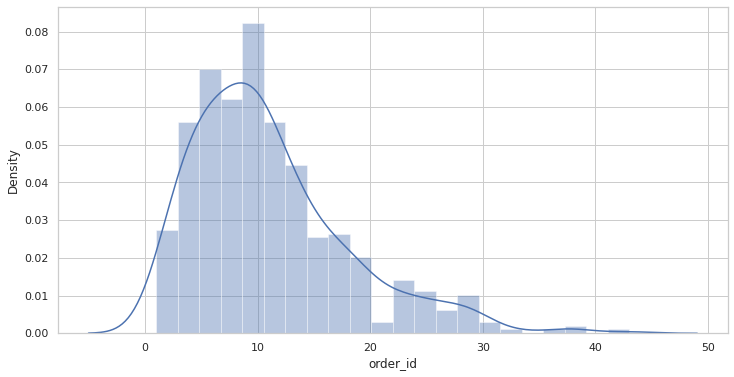

In [87]:
sns.distplot(control_df.order_id)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


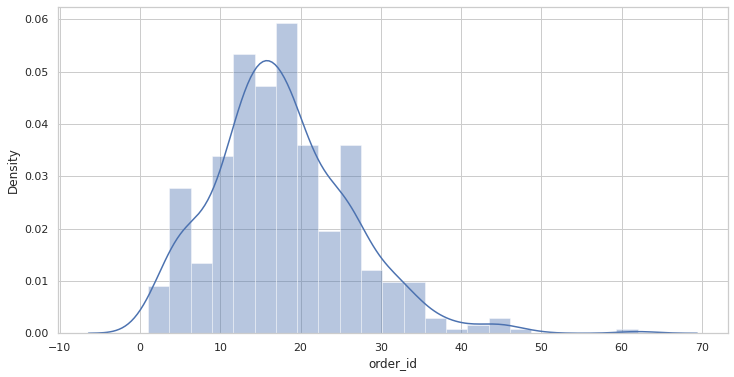

In [99]:
sns.distplot(test_df.order_id)

Найдём взаимосвязь между активностью пользователями и типом группы.

Используя, Хи-квадрат, поскольку одна из переменных категориальная.

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [95]:
# Проверим результат с помощью statsmodels
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_data.group, users_data.action))

In [96]:
stat, p, dof, expected 

(0.018211165651942023,
 0.8926523935841298,
 1,
 array([[  83.43878257, 1607.56121743],
        [ 130.56121743, 2515.43878257]]))

In [97]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Следовательно, нулевая гипотеза не отклоняется, то есть взаимосвязи между переменными нет.

## Выбор  второй метрики
Кроме того, для оценки эффективности нового алгоритма рекомендаций в приложении доставки, будет логично и эффективно использовать метрику **средней суммы продаж по дням**, поскольку временной период составляет всего 14 дней.

In [163]:
control.head()

,group,user_id,order_id,action,date,product_id,name,price
0,0,964,1255,create_order,2022-08-26,75,сок ананасовый,120.0
1,0,964,1255,create_order,2022-08-26,22,сок мультифрукт,120.0
2,0,964,1255,create_order,2022-08-26,53,мука,78.3
3,0,964,1255,create_order,2022-08-26,84,мандарины,90.4
7,0,964,1257,create_order,2022-08-26,76,чай черный в пакетиках,55.5


In [165]:
avg_revenue_control = control.groupby('date').agg({'price':'sum'}).reset_index()
avg_revenue_control

,date,price
0,2022-08-26,251223.5
1,2022-08-27,44756.8
2,2022-08-28,33434.0
3,2022-08-29,49567.3
4,2022-08-30,35485.3
5,2022-08-31,29130.3
6,2022-09-01,31623.5
7,2022-09-02,35481.7
8,2022-09-03,27697.1
9,2022-09-04,30832.4


In [167]:
avg_revenue_control['sales_by_date'] = avg_revenue_control['price']/avg_revenue_control.shape[0]
avg_revenue_control

,date,price,sales_by_date
0,2022-08-26,251223.5,17944.535714
1,2022-08-27,44756.8,3196.914286
2,2022-08-28,33434.0,2388.142857
3,2022-08-29,49567.3,3540.521429
4,2022-08-30,35485.3,2534.664286
5,2022-08-31,29130.3,2080.735714
6,2022-09-01,31623.5,2258.821429
7,2022-09-02,35481.7,2534.407143
8,2022-09-03,27697.1,1978.364286
9,2022-09-04,30832.4,2202.314286


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


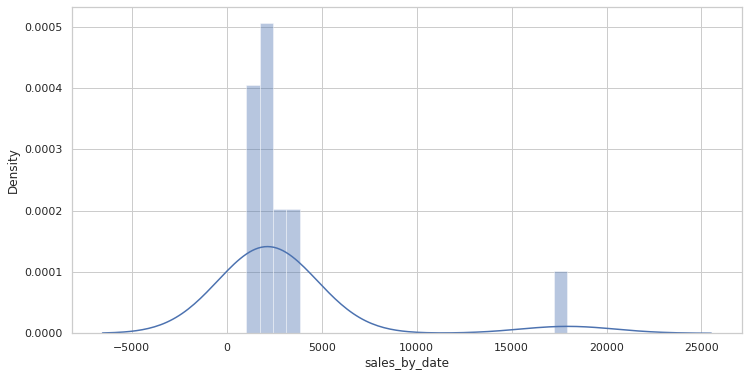

In [169]:
sns.distplot(avg_revenue_control.sales_by_date)

In [171]:
import matplotlib.pyplot as plt

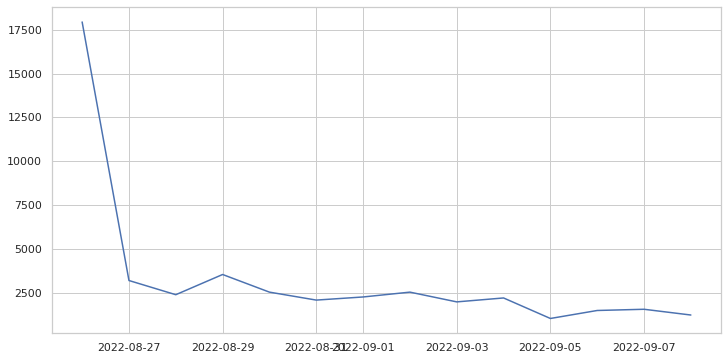

In [172]:
plt.plot(avg_revenue_control.date, avg_revenue_control.sales_by_date)

In [147]:
test.head()

,group,user_id,order_id,action,date,product_id,name,price
4,1,965,1256,create_order,2022-08-26,56,сосиски,150.0
5,1,965,1256,create_order,2022-08-26,76,чай черный в пакетиках,55.5
6,1,965,1256,create_order,2022-08-26,39,бублики,45.0
15,1,967,1259,create_order,2022-08-26,20,батон,50.0
16,1,967,1259,create_order,2022-08-26,45,чай зеленый листовой,78.0


In [173]:
avg_revenue_test = test.groupby('date').agg({'price':'sum'}).reset_index()
avg_revenue_test

,date,price
0,2022-08-26,260790.2
1,2022-08-27,79017.4
2,2022-08-28,79998.7
3,2022-08-29,92987.0
4,2022-08-30,57847.2
5,2022-08-31,49508.0
6,2022-09-01,54165.6
7,2022-09-02,54685.0
8,2022-09-03,65751.8
9,2022-09-04,59204.2


In [174]:
avg_revenue_test['sales_by_date'] = avg_revenue_test['price']/avg_revenue_test.shape[0]
avg_revenue_test

,date,price,sales_by_date
0,2022-08-26,260790.2,18627.871429
1,2022-08-27,79017.4,5644.100000
2,2022-08-28,79998.7,5714.192857
3,2022-08-29,92987.0,6641.928571
4,2022-08-30,57847.2,4131.942857
5,2022-08-31,49508.0,3536.285714
6,2022-09-01,54165.6,3868.971429
7,2022-09-02,54685.0,3906.071429
8,2022-09-03,65751.8,4696.557143
9,2022-09-04,59204.2,4228.871429


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


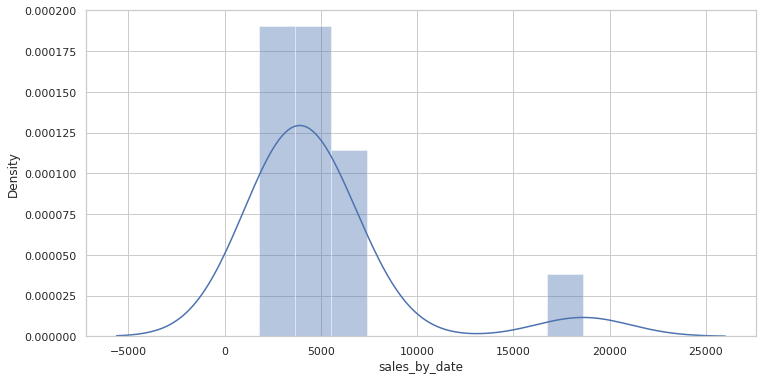

In [175]:
sns.distplot(avg_revenue_test.sales_by_date)

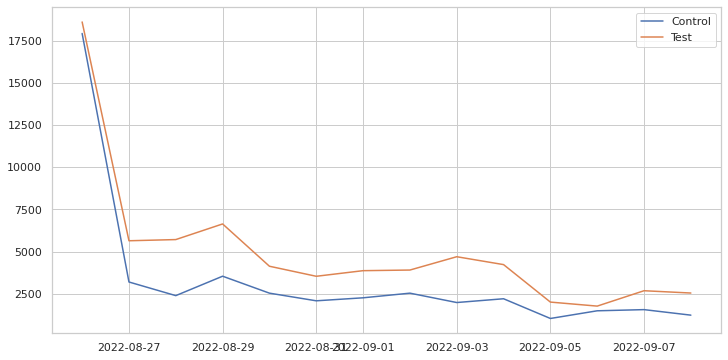

In [179]:
plt.plot(avg_revenue_control.date, avg_revenue_control.sales_by_date, label='Control')
plt.plot(avg_revenue_test.date, avg_revenue_test.sales_by_date, label='Test')

plt.legend()

Средняя сумма продаж в обеих группах резко снизилась, однако показатель выше у тестовой группы по сравнению с контрольной.

Рассмотрим однородность двух выборок, сравнив между собой, воспользуемся t-критерием Стьюдента.

Гипотезы:
- $H_0$: в генеральной совокупности никакого различия между средними значениями нет
- $H_1$: средние в генеральной совокупности не равны

In [106]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

Применяя Т-критерий Стьюдента нужно помнить о следующем:
1. Дисперсии должны быть приблизительно равны (проверим с помощью критерия Левена)

In [109]:
stats.levene(control.price, test.price, center='median')

LeveneResult(statistic=1.2671888044889503, pvalue=0.2603132671841267)

In [110]:
stats.levene(control.price, test.price, center='mean')

LeveneResult(statistic=4.249047971963379, pvalue=0.03929004492489723)

In [112]:
pg.normality(data=full_data_df, dv="price", 
                   group="group", method="normaltest")

,W,pval,normal
0,2654.913471,0.0,False
1,4328.515222,0.0,False


In [114]:
stats.normaltest(control.price)

NormaltestResult(statistic=2654.9134711328516, pvalue=0.0)

In [115]:
stats.normaltest(test.price)

NormaltestResult(statistic=4328.515222032584, pvalue=0.0)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


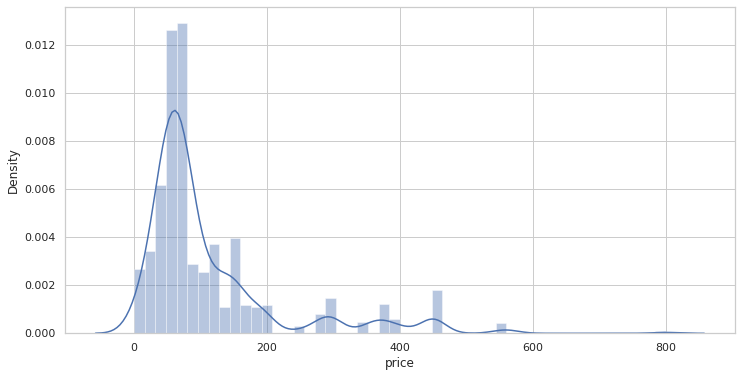

In [116]:
sns.distplot(control.price)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


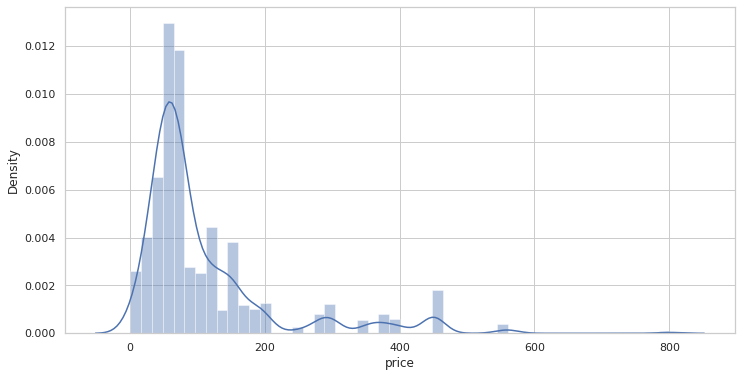

In [117]:
sns.distplot(test.price)

В обоих методах p-значение различное, где центром является медиана p-value составляет более 0,05, а при среднем - менее 0,05. Это означает, что в одном случае из двух мы смогли бы отвергнуть нулевую гипотезу.

2. Требование к нормальности, но поскольку наша размерность выборок невелика, можем не опираться на данный пункт. 

Проверим также с помощью бутстрапа адекватность полученных критериев.

In [185]:
ttest_ind(test.price, control.price)

Ttest_indResult(statistic=-1.731078581117817, pvalue=0.08345892434326715)

Исходя из полученного значения p-value, которое больше 0,05, мы не можем отклонить нулевую гипотезу. Однако, вследствие ненормальности распределения, проведём методику бутстрап. 

In [186]:
stats.bootstrap((control.price, ), np.median, method='percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=75.0, high=75.4), standard_error=0.10486528595548292)

In [187]:
stats.bootstrap((test.price, ), np.median, method='percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=70.3, high=75.3), standard_error=1.0829812409518043)

## Вывод


Доверительные интервалы пересекаются , это значит, что с высокой степенью вероятности средние значения в генеральных совокупностях одинаковы.

В этом случае гипотеза о совпадении средних в генеральных совокупностях не отклоняется, а различие между выборочными средними считается статистически незначимым (несущественным). Нулевая гипотеза не отклоняется.

Были проанализированы 2 метрики, которые указали на то, что новая система рекомендаций не так успешна, статистической значимости нет.

`Процент отмен заказов` и `Средняя сумма продаж по дням` показали неэффективность нового алгоритма.